In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")
from statsmodels.api import qqplot
import statsmodels.api as sm
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.api as sm

In [ ]:
df = pd.read_csv('/content/road_accident.csv')
df.head()

,Date,Total_Accident
0,01/01/2014,267
1,02/01/2014,328
2,03/01/2014,308
3,04/01/2014,272
4,05/01/2014,269


In [ ]:
df.tail(1)

,Date,Total_Accident
1460,31/12/2017,188


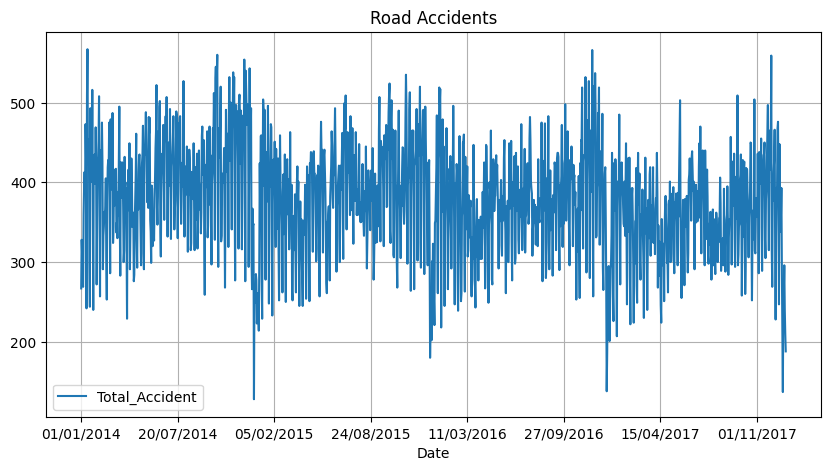

In [ ]:
df.set_index('Date', inplace=True)
df.plot(figsize=(10, 5))
plt.grid()
plt.title('Road Accidents')
plt.xlabel('Date')
plt.show()

In [ ]:
df.index = pd.to_datetime(df.index, format='%d/%m/%Y')
y = df.copy()
print(y.head())
print(y.info())

            Total_Accident
Date                      
2014-01-01             267
2014-01-02             328
2014-01-03             308
2014-01-04             272
2014-01-05             269
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1461 entries, 2014-01-01 to 2017-12-31
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Total_Accident  1461 non-null   int64
dtypes: int64(1)
memory usage: 22.8 KB
None


### **Monthwise visualization**

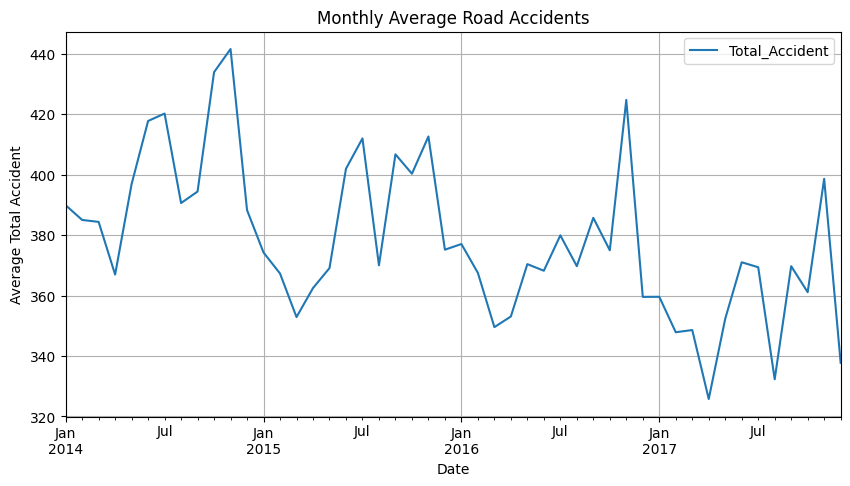

In [ ]:
y.resample('ME').mean().plot(figsize=(10, 5))
plt.grid()
plt.title('Monthly Average Road Accidents')
plt.xlabel('Date')
plt.ylabel('Average Total Accident')
plt.show()

### **Weekwise visualization**

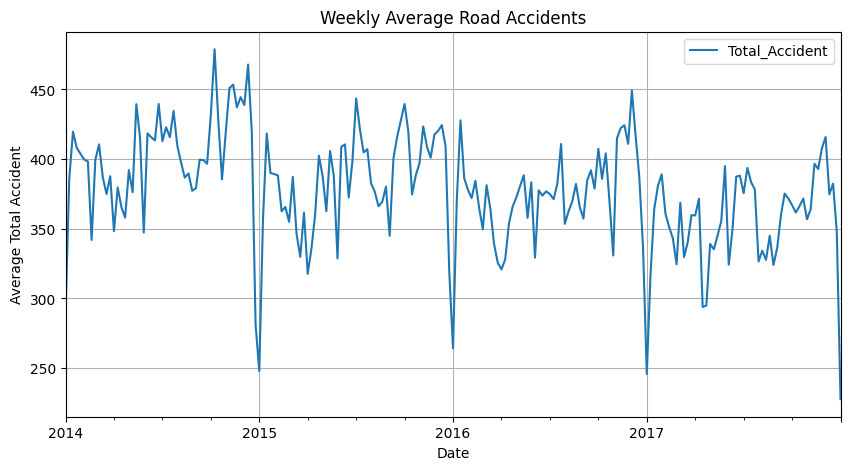

In [ ]:
y.resample('W').mean().plot(figsize=(10, 5))
plt.grid()
plt.title('Weekly Average Road Accidents')
plt.xlabel('Date')
plt.ylabel('Average Total Accident')
plt.show()

- **The plot shows a clear downward trend in total accidents over time (from ~450 to ~200)**
- **peaks appear at regular intervals (need seasonal decomposition)**

## **Stationary test on monthly & weekly data**

In [ ]:
result = adfuller(y.resample('ME').mean())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.244085
p-value: 0.654350
Critical Values:
	1%: -3.621
	5%: -2.944
	10%: -2.610


In [ ]:
y = y.resample('W').mean()
result = adfuller(y)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.186729
p-value: 0.000009
Critical Values:
	1%: -3.462
	5%: -2.876
	10%: -2.574


- **We can see that the weekly series shows evidence of stationarity, while the monthly does not, likely because the signs of stationarity are lost when the data is aggregated.**
- **We will use weekly for modeling to preserve short-term dynamics.**
- **We do not need to decompose for weekly data**
- **We can directly model it using ARIMA or other methods without differencing or decomposition**



## **Persistence model**

In [ ]:
y = np.log(y)
train, test = y.iloc[:-12], y.iloc[-12:]
persistence_forecast = np.repeat(train.iloc[-1], len(test))

persistence_mae = mean_absolute_error(test, persistence_forecast)
persistence_rmse = np.sqrt(mean_squared_error(test, persistence_forecast))

print(f"Persistence Model - MAE: {persistence_mae:.2f}, RMSE: {persistence_rmse:.2f}")

Persistence Model - MAE: 0.09, RMSE: 0.15


<Figure size 800x400 with 0 Axes>

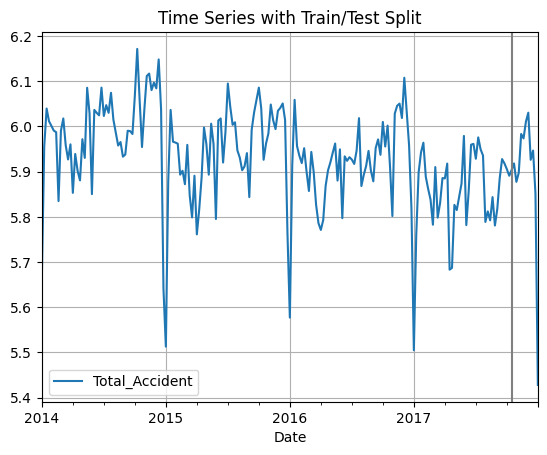

In [ ]:
plt.figure(figsize=(8, 4))
y.plot(title="Time Series with Train/Test Split")
plt.axvline(x=y.index[-12], color='gray')
plt.grid()
plt.show()

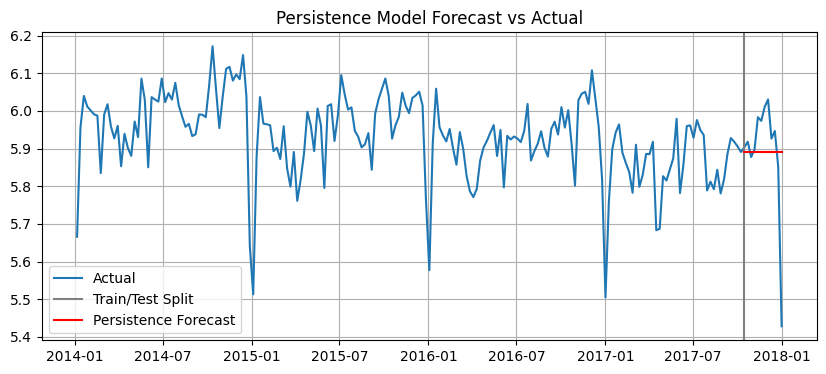

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(y.index, y.values, label='Actual')
plt.axvline(x=test.index[0], color='gray', label='Train/Test Split')
plt.plot(test.index, persistence_forecast, label='Persistence Forecast', color='red')
plt.legend()
plt.title('Persistence Model Forecast vs Actual')
plt.grid()
plt.show()

### **Naive forecast**

- **Forecast = Value from the same season in the previous cycle (Ŷ{t+1} = Y{t+1-m}, m = seasonality period)**
- **Though ADF test suggests stationarity, a seasonal naive model might outperform persistence**
- **Below we implement seasonal naive model assumes the same value as 12 weeks ago**


In [ ]:
seasonal_naive = y.shift(12).iloc[-12:]
seasonal_mae = mean_absolute_error(test, seasonal_naive)
seasonal_rmse = np.sqrt(mean_squared_error(test, seasonal_naive))
print(f"Seasonal Naive - MAE: {seasonal_mae:.2f}, RMSE: {seasonal_rmse:.2f}")

Seasonal Naive - MAE: 0.13, RMSE: 0.17


## **The above results shows persistence model is better than the seasonal naive model.**

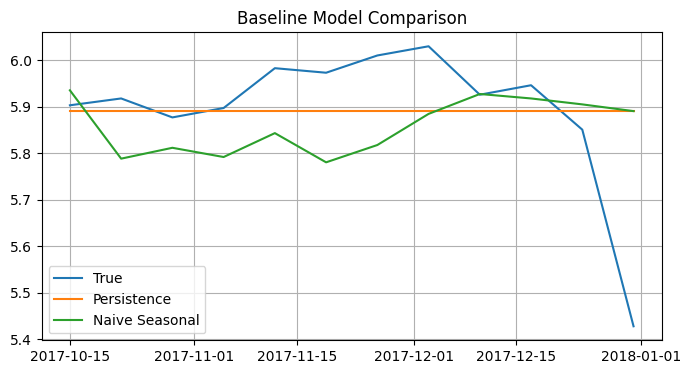

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(test.index, test, label='True')
plt.plot(test.index, persistence_forecast, label='Persistence')
plt.plot(test.index, seasonal_naive, label='Naive Seasonal')
plt.title('Baseline Model Comparison')
plt.legend()
plt.grid()
plt.show()

## **ARIMA model -> Grid search (p,d,q)**

In [22]:
def evaluate_arima_model(y, arima_order):
    train_size = int(len(y) * 0.80)
    train, test = y[0:train_size], y[train_size:]
    history = list(train)

    predictions = []
    for t in range(len(test)):
        try:
            model = ARIMA(history, order=arima_order)
            model_fit = model.fit()
            yhat = model_fit.forecast()[0]
            predictions.append(yhat)
            history.append(test[t])
        except:
            return np.inf

    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    print(f'ARIMA{order} RMSE={rmse:.3f}')
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                except:
                    continue
    print(f'\n Best ARIMA{best_cfg} RMSE={best_score:.3f}')
    return best_cfg

p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)

best_order = evaluate_models(y.values, p_values, d_values, q_values)
print(best_order)

ARIMA(0, 0, 0) RMSE=0.122
ARIMA(0, 0, 1) RMSE=0.101
ARIMA(0, 0, 2) RMSE=0.099
ARIMA(0, 1, 0) RMSE=0.098
ARIMA(0, 1, 1) RMSE=0.099
ARIMA(0, 1, 2) RMSE=0.095
ARIMA(0, 2, 0) RMSE=0.124
ARIMA(0, 2, 1) RMSE=0.098
ARIMA(0, 2, 2) RMSE=0.099
ARIMA(1, 0, 0) RMSE=0.098
ARIMA(1, 0, 1) RMSE=0.098
ARIMA(1, 0, 2) RMSE=0.097
ARIMA(1, 1, 0) RMSE=0.098
ARIMA(1, 1, 1) RMSE=0.095
ARIMA(1, 1, 2) RMSE=0.094
ARIMA(1, 2, 0) RMSE=0.114
ARIMA(1, 2, 1) RMSE=0.098
ARIMA(1, 2, 2) RMSE=0.097
ARIMA(2, 0, 0) RMSE=0.098
ARIMA(2, 0, 1) RMSE=0.097
ARIMA(2, 0, 2) RMSE=0.097
ARIMA(2, 1, 0) RMSE=0.097
ARIMA(2, 1, 1) RMSE=0.095
ARIMA(2, 1, 2) RMSE=0.094
ARIMA(2, 2, 0) RMSE=0.104
ARIMA(2, 2, 1) RMSE=0.097
ARIMA(2, 2, 2) RMSE=0.095
ARIMA(4, 0, 0) RMSE=0.097
ARIMA(4, 0, 1) RMSE=0.097
ARIMA(4, 0, 2) RMSE=0.097
ARIMA(4, 1, 0) RMSE=0.099
ARIMA(4, 1, 1) RMSE=0.095
ARIMA(4, 1, 2) RMSE=0.094
ARIMA(4, 2, 0) RMSE=0.103
ARIMA(4, 2, 1) RMSE=0.099
ARIMA(4, 2, 2) RMSE=0.098
ARIMA(6, 0, 0) RMSE=0.098
ARIMA(6, 0, 1) RMSE=0.098
ARIMA(6, 0, 

In [31]:
model = ARIMA(y, order=best_order).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:         Total_Accident   No. Observations:                  209
Model:                ARIMA(10, 1, 2)   Log Likelihood                 211.880
Date:                Mon, 28 Jul 2025   AIC                           -397.759
Time:                        02:42:14   BIC                           -354.371
Sample:                    01-05-2014   HQIC                          -380.215
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1195      0.163     -0.731      0.465      -0.440       0.201
ar.L2          0.2528      0.162      1.557      0.119      -0.065       0.571
ar.L3         -0.0691      0.116     -0.598      0.5

## **Diagnostics plot**

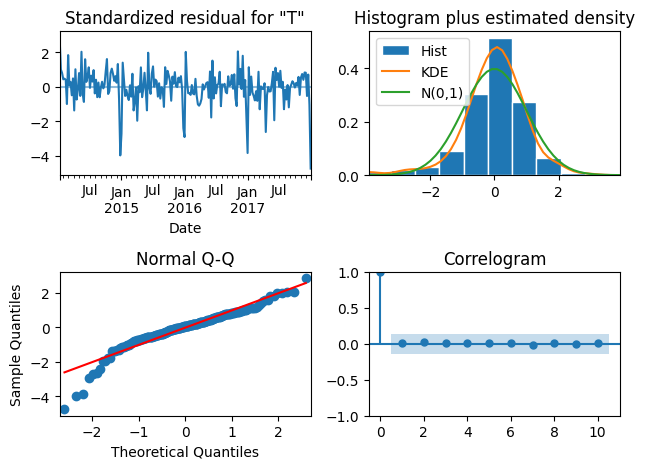

In [24]:
model.plot_diagnostics()
plt.tight_layout()
plt.show()

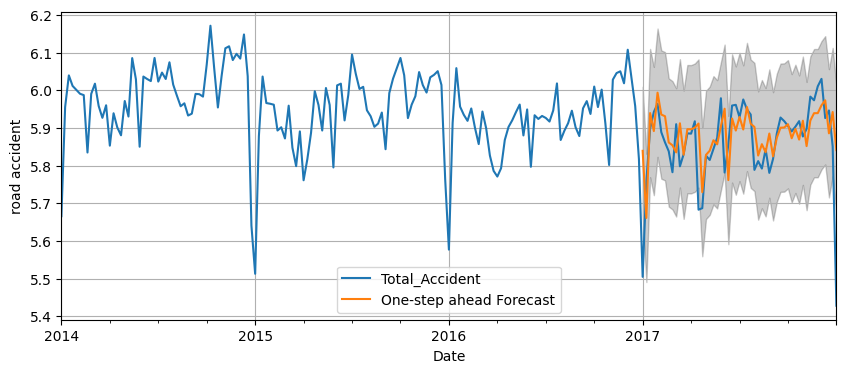

In [32]:
pred = model.get_prediction(start=y.index[y.index.year == 2017][0], dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', figsize=(10, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('road accident')
plt.legend()
plt.grid()
plt.show()

## **Mean Squared Error**

In [34]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]['Total_Accident']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.01


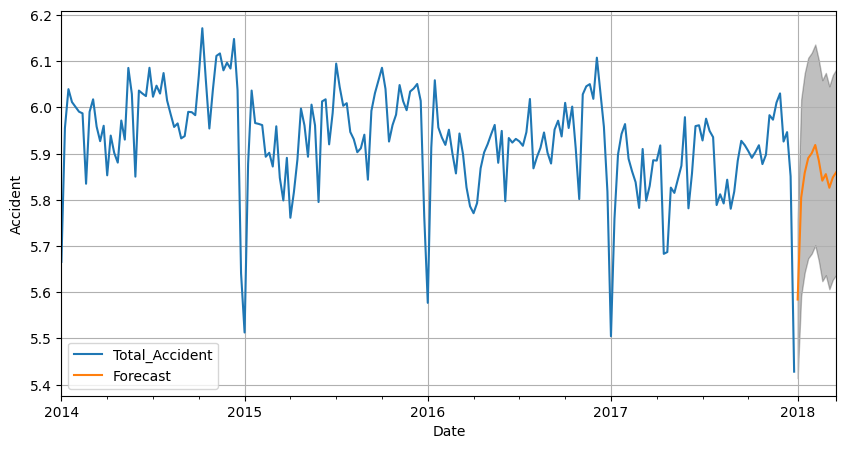

In [40]:
pred_uc = model.get_forecast(steps=12)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(10, 5))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Accident')
plt.legend()
plt.grid()
plt.show()

## **Decomposition**

### **Decomposition splits series into:**
- **Trend (long-term increase/decrease), Seasonality (regular patterns): remove trend/ seasonality so we can model only the stationary part (residuals)**
- **Residual (random noise)**

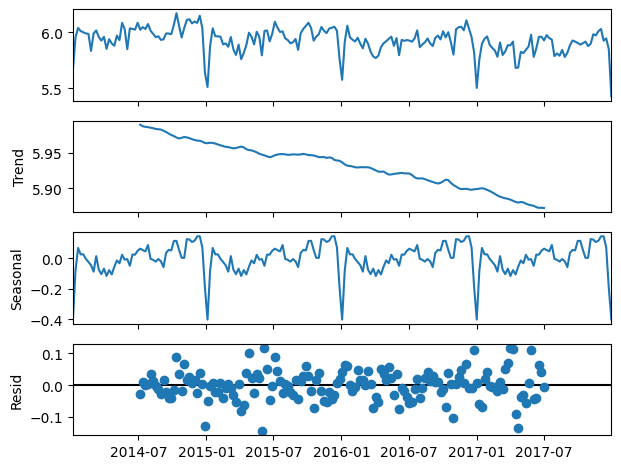

In [41]:
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

## **Grid Search-SARIMAX**

In [44]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
best_aic = float("inf")
best_param = None
best_param_seasonal = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_invertibility=False)

            results = mod.fit()

            if results.aic < best_aic:
                best_aic = results.aic
                best_param = param
                best_param_seasonal = param_seasonal

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

print('\n\n\n')
print('****************')
print(f'Best AIC: {best_aic}')
print(f'Best (p,d,q): {best_param}')
print(f'Best seasonal (P,D,Q,m): {best_param_seasonal}')

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1339.2485629496607
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1098.8438125874457
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:-185.48538746873191
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-272.02562227557803
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-106.69252604094092
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-177.36746381744908
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-222.85649616900122
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-270.02691854841794
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1059.0723779343439
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:818.5845775207479
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-261.7909723945839
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-347.00594964070365
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-195.96625528396027
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-265.9327693492438
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-305.43060354646326
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-345.0094772662917
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-365.89069697390175
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-3

## **SARIMA**

In [45]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=best_param,
                                seasonal_order=best_param_seasonal,
                                enforce_invertibility=False).fit()
print(mod.summary())

                                     SARIMAX Results                                      
Dep. Variable:                     Total_Accident   No. Observations:                  209
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 12)   Log Likelihood                 203.855
Date:                            Mon, 28 Jul 2025   AIC                           -399.710
Time:                                    02:57:15   BIC                           -386.359
Sample:                                01-05-2014   HQIC                          -394.312
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5582      0.049     11.317      0.000       0.461       0.655
ma.L1         -1.0300      0.031   

## **Diagnostics**

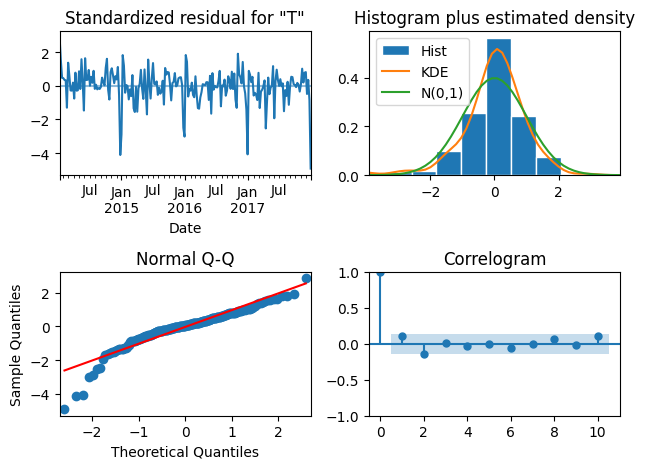

In [47]:
mod.plot_diagnostics()
plt.tight_layout()
plt.show()

## **Compare with actual**

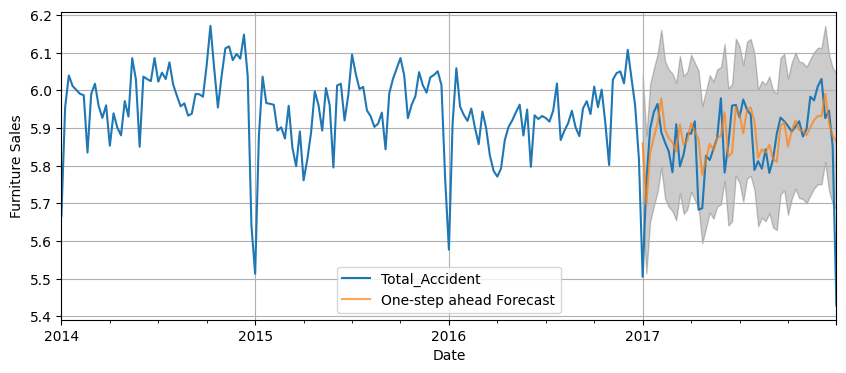

In [51]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(10, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.grid()
plt.show()

In [53]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]['Total_Accident']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.01


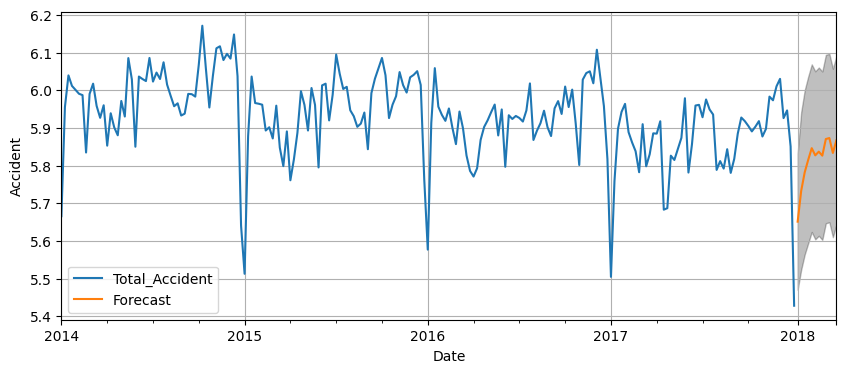

In [57]:
pred_uc = results.get_forecast(steps=12)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(10, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Accident')
plt.legend()
plt.grid()
plt.show()

## **Exponential Smoothing**

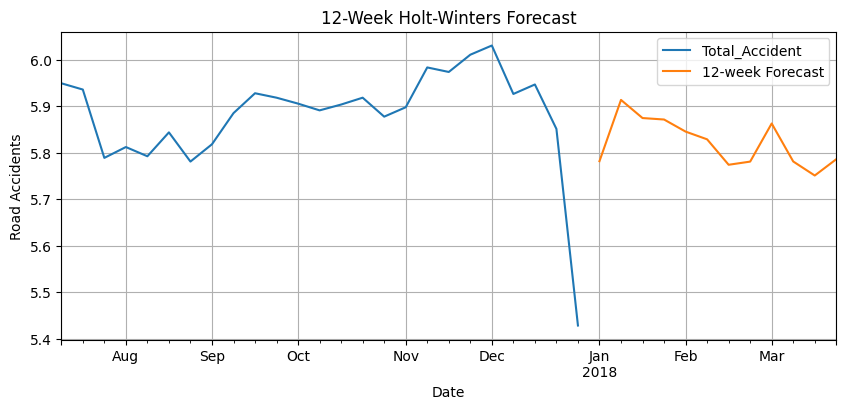

In [27]:
model = ExponentialSmoothing(
    y,
    trend='add',
    seasonal='add',
    seasonal_periods=52).fit()

forecast = model.forecast(steps=12)

ax = y[-25:].plot(label='Observed', figsize=(10, 4))
forecast.plot(ax=ax, label='12-week Forecast')

ax.set_xlabel('Date')
ax.set_ylabel('Road Accidents')
plt.title("12-Week Holt-Winters Forecast")
plt.legend()
plt.grid()
plt.show()

## **Comparison**

In [58]:
persistence_forecast = np.repeat(y.iloc[-13], 12)
persistence_mae = mean_absolute_error(test, persistence_forecast)
persistence_rmse = np.sqrt(mean_squared_error(test, persistence_forecast))

arima_model = ARIMA(y[:-12], order=(10,1,2)).fit()
arima_forecast = arima_model.forecast(steps=12)
arima_mae = mean_absolute_error(test, arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))

sarima_forecast = mod.forecast(steps=12)
sarima_mae = mean_absolute_error(test, sarima_forecast)
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_forecast))

hw_model = ExponentialSmoothing(
    y[:-12],
    trend='add',
    seasonal='add',
    seasonal_periods=52).fit()
hw_forecast = hw_model.forecast(steps=12)
hw_mae = mean_absolute_error(test, hw_forecast)
hw_rmse = np.sqrt(mean_squared_error(test, hw_forecast))

comparison = pd.DataFrame({
    'Model': ['Persistence', 'ARIMA(10,1,2)', 'SARIMA(1,1,1)(0,0,1,12)', 'Holt-Winters'],
    'MAE': [persistence_mae, arima_mae, sarima_mae, hw_mae],
    'RMSE': [persistence_rmse, arima_rmse, sarima_rmse, hw_rmse]})

comparison.sort_values('RMSE')

,Model,MAE,RMSE
3,Holt-Winters,0.047491,0.068241
1,"ARIMA(10,1,2)",0.093573,0.149085
0,Persistence,0.090653,0.150099
2,"SARIMA(1,1,1)(0,0,1,12)",0.158155,0.199435
